In [119]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from brian2 import*
import functions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 23. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Started simulate
Finished simulate in 28.951565265655518
Started spike_times_to_matrix
Finished spike_times_to_matrix in 1264.9033133983612


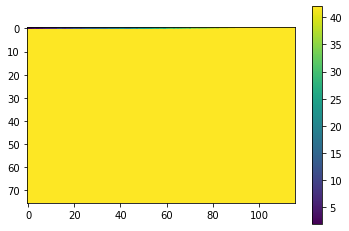

In [89]:


def time_me(func):
    def wrapper(*args, **kwargs):
        t = time()
        print("Started", func.__name__)
        result = func(*args, **kwargs)
        print("Finished", func.__name__, "in", time() - t)
        return result
    return wrapper

@time_me
def simulate(nNeurons=100, simTime=50):
    start_scope()

    P = PoissonGroup(nNeurons, 100*np.arange(nNeurons) * Hz + 1000 * Hz)
    G = NeuronGroup(nNeurons, 'dv/dt = -v / (10*ms) : 1', threshold='v>1', reset='v = 0', method='exact')
    S = Synapses(P, G, on_pre='v+=0.1')
    S.connect(j='i')

    M = SpikeMonitor(G, variables='v')

    run(simTime*ms)

    return M


@time_me
def spike_times_to_matrix(spikeMon, nX, nY, startTime, endTime, nBins):
    resArr = np.zeros((nX, nY, nBins))
    tStep = float((endTime - startTime) / nBins)

    coord1Dto2D = lambda i: (i // nY, i % nY)
    time2bin = lambda t: int((t - startTime) / tStep)

    for iNeuron, tList in spikeMon.all_values()['t'].items():
        x, y = coord1Dto2D(iNeuron)
        for t in tList:
            my_bin = time2bin(t)
            resArr[x, y, my_bin] += 1

    return resArr

nX = 76
nY = 116
simTime = 100
M = simulate(nNeurons=nX*nY, simTime=simTime)

arr = spike_times_to_matrix(M, nX, nY, 0*ms, simTime*ms, 2)

plt.figure()
plt.imshow(arr[:,:,-1])
plt.colorbar()
plt.show()

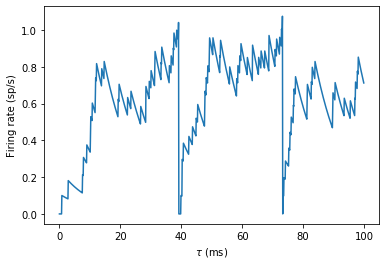

In [115]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()

M = StateMonitor(G, 'v', record=0)
# Store the current state of the network
net = Network(SGG, G, S, M)

net.run(100*ms)
plot(M.t / ms, M.v[0])
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

In [116]:
scheduling_summary()

object,part of,Clock dt,when,order,active
statemonitor_3 (StateMonitor),statemonitor_3 (StateMonitor),100. us (every step),start,0,yes
neurongroup_3_stateupdater (StateUpdater),neurongroup_3 (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_3_thresholder (Thresholder),neurongroup_3 (NeuronGroup),100. us (every step),thresholds,0,yes
poissongroup_1_thresholder (Thresholder),poissongroup_1 (PoissonGroup),100. us (every step),thresholds,0,yes
spikegeneratorgroup_3 (SpikeGeneratorGroup),spikegeneratorgroup_3 (SpikeGeneratorGroup),100. us (every step),thresholds,0,yes
spikemonitor_1 (SpikeMonitor),spikemonitor_1 (SpikeMonitor),100. us (every step),thresholds,1,yes
synapses_3_pre (SynapticPathway),synapses_3 (Synapses),100. us (every step),synapses,-1,yes
neurongroup_3_resetter (Resetter),neurongroup_3 (NeuronGroup),100. us (every step),resets,0,yes


In [132]:
from brian2 import *
ta = TimedArray([1, 0, 0, 0] , dt=0.1*ms)
print(ta(0.3*ms))
G = NeuronGroup(1, 'v = ta(t) : 1')
mon = StateMonitor(G, 'v', record=True)
net = Network(G, mon)
net.run(1*ms)  # doctest: +ELLIPSIS

0.0


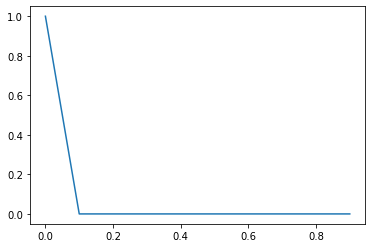

In [133]:
plot(mon.t / ms, mon.v[0])

In [ ]:

ta2d = TimedArray([[1, 2], [3, 4], [5, 6]]*mV, dt=0.1*ms)
G = NeuronGroup(4, 'v = ta2d(t, i%2) : volt')
mon = StateMonitor(G, 'v', record=True)
net = Network(G, mon)
net.run(0.2*ms)  # doctest: +ELLIPSIS

print(mon.v[:])

In [ ]:
eqs = """
dv/dt : - (v - 5)"""